In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'xxxxx'
os.environ['KAGGLE_KEY'] = 'xxxxxxxxxxxxxxxxxxxxxx'

In [44]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:15<00:00, 124MB/s]
100% 1.15G/1.15G [00:15<00:00, 78.9MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove

from pathlib import Path

The dataset is divided into three sets: 1) train set 2) validation set and 3) test set

In [0]:

# Path to train directory (Fancy pathlib...no more os.path!!)
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

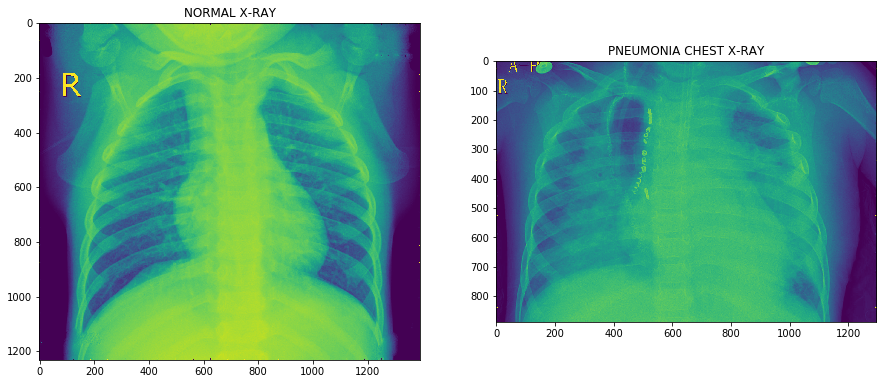

In [48]:
from glob import glob

#plots for NORMAL and PNEOMONIA in the folder
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
img = np.asarray(plt.imread(glob(train_dir+"/NORMAL/*.jpeg")[5]))
plt.title('NORMAL X-RAY')
plt.imshow(img)

plt.subplot(1 , 2 , 2)
img = np.asarray(plt.imread(glob(train_dir+"/PNEUMONIA/*.jpeg")[0]))
plt.title('PNEUMONIA CHEST X-RAY')
plt.imshow(img)

plt.show()

In [0]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
  

In [65]:
rescale = 1./255.0
target_size = (150, 150)

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255.0
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode='binary',
    batch_size=32
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode='binary',
    batch_size=32
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=32,
    class_mode='binary',
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [62]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)
model = Sequential()
model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_943 (Bat (None, 1024)              4096      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 2050      
Total params: 23,907,106


In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/5
 79/163 [=============>................] - ETA: 11:56 - loss: 0.7933 - acc: 0.6566